<a href="https://colab.research.google.com/github/orangNLP/NLP_practice-PUB-/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 텍스트 분류

## **□데이터 다운 및 캐글 연동**

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"orangkim","key":"83a095e75a3ad155f345dcb4416820d1"}'}

In [2]:
# json 파일 ~/.kaggle로 이동시키기
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c word2vec-nlp-tutorial

 99% 51.0M/51.7M [00:00<00:00, 105MB/s] 
100% 51.7M/51.7M [00:00<00:00, 93.1MB/s]


In [4]:
from ast import increment_lineno
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from bs4 import BeautifulSoup
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
import tensorflow.keras.layers
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
os.listdir()

['.config', 'kaggle.json', 'word2vec-nlp-tutorial.zip', 'sample_data']

In [6]:
os.mkdir('./data_in')

In [7]:
!unzip word2vec-nlp-tutorial.zip

Archive:  word2vec-nlp-tutorial.zip
  inflating: labeledTrainData.tsv.zip  
  inflating: sampleSubmission.csv    
  inflating: testData.tsv.zip        
  inflating: unlabeledTrainData.tsv.zip  


In [8]:
!unzip labeledTrainData.tsv.zip
!unzip unlabeledTrainData.tsv.zip
!unzip testData.tsv.zip

Archive:  labeledTrainData.tsv.zip
  inflating: labeledTrainData.tsv    
Archive:  unlabeledTrainData.tsv.zip
  inflating: unlabeledTrainData.tsv  
Archive:  testData.tsv.zip
  inflating: testData.tsv            


In [9]:
import shutil
shutil.move('/content/labeledTrainData.tsv','/content/data_in/labeledTrainData.tsv')
shutil.move('/content/sampleSubmission.csv','/content/data_in/sampleSubmission.csv')
shutil.move('/content/testData.tsv','/content/data_in/testData.tsv')
shutil.move('/content/unlabeledTrainData.tsv','/content/data_in/unlabeledTrainData.tsv')

'/content/data_in/unlabeledTrainData.tsv'

In [10]:
DATA_IN_PATH = './data_in/'
train_data = pd.read_csv(DATA_IN_PATH + 'labeledTrainData.tsv', header = 0, delimiter = '\t', quoting = 3) #delimiter = 구분자, quoting = 3 따옴표 그대로 출력

## **□데이터 이해**

In [11]:
train_data.head() #.head -> 앞에 5개의 데이터 확인

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [12]:
# 데이터 크기 확인
print("파일 크기: ")
for file in os.listdir(DATA_IN_PATH):
  if 'tsv' in file and 'zip' not in file:
    print(file.ljust(30)+str(round(os.path.getsize(DATA_IN_PATH + file) / 1000000, 2)) + 'MB')

파일 크기: 
labeledTrainData.tsv          33.56MB
unlabeledTrainData.tsv        67.28MB
testData.tsv                  32.72MB


In [13]:
print('전체 학습 데이터의 개수: {}'.format(len(train_data)))

전체 학습 데이터의 개수: 25000


In [14]:
train_length = train_data['review'].apply(len) #.apply DataFrame에 인자에 해당하는 함수를 적용하는 메서드
train_length.head()

0    2304
1     948
2    2451
3    2247
4    2233
Name: review, dtype: int64

Text(0, 0.5, 'Number of review')

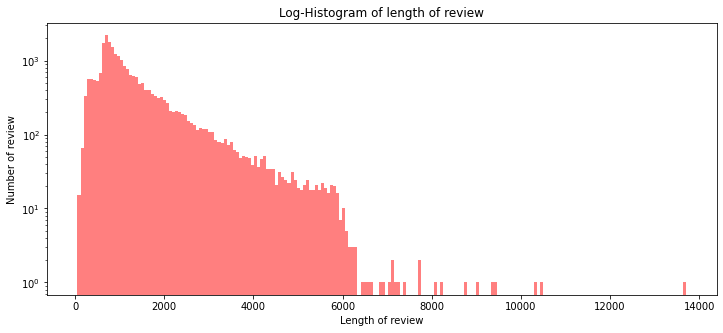

In [15]:
#review 데이터 형태 확인을 위해 히스토그램 그리기
plt.figure(figsize = (12,5))
plt.hist(train_length, bins = 200, alpha = 0.5, color = 'r', label = 'word')
plt.yscale('log', nonposy = 'clip') #nonposy = 유효하지 않은 값을 아주 작은 값으로 잘라냄
plt.title('Log-Histogram of length of review')
plt.xlabel('Length of review')
plt.ylabel('Number of review')

In [16]:
#review 데이터 형태 확인을 위한 통계값 출력
print('리뷰 길이 최댓값: {}'.format(np.max(train_length)))
print('리뷰 길이 최솟값: {}'.format(np.min(train_data)))
print('리뷰 길이 평균값: {:.2f}'.format(np.mean(train_length)))
print('리뷰 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('리뷰 길이 중간값: {}'.format(np.median(train_length)))
print('리뷰 길이 제1사분위: {}'.format(np.percentile(train_length,25)))
print('리뷰 길이 제3사분위: {}'.format(np.percentile(train_length,75)))

리뷰 길이 최댓값: 13710
리뷰 길이 최솟값: id                                                       "0_3"
sentiment                                                    0
review       "A Turkish Bath sequence in a film noir lo...
dtype: object
리뷰 길이 평균값: 1329.71
리뷰 길이 표준편차: 1005.22
리뷰 길이 중간값: 983.0
리뷰 길이 제1사분위: 705.0
리뷰 길이 제3사분위: 1619.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f451850e5e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f451850eca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f451850e280>],
 'medians': [<matplotlib.lines.Line2D at 0x7f45185253a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f4518525a00>],
 'means': [<matplotlib.lines.Line2D at 0x7f45185256a0>]}

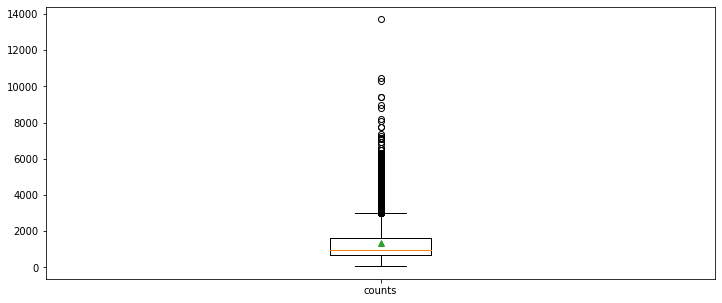

In [17]:
#review 데이터 형태 확인을 위한 박스플롯 출력
plt.figure(figsize=(12,5))
plt.boxplot(train_length,
            labels = ['counts'],
            showmeans=True) #showmeans: 평균값 마크 유무

(-0.5, 799.5, 599.5, -0.5)

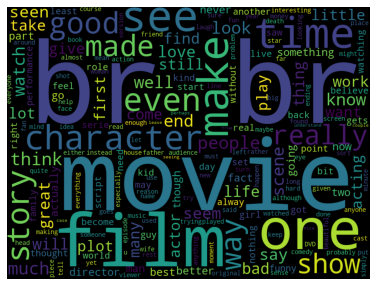

In [18]:
#review 데이터 형태 확인을 위한 워드클라우드 출력
from wordcloud import WordCloud
cloud = WordCloud(width = 800, height = 600).generate(" ".join(train_data['review'])) #문자열로 인자 전달을 위해 공백 삽입 후 join
plt.figure(figsize=(12,5))
plt.imshow(cloud)
plt.axis('off')

In [19]:
#단어 개수 확인
train_word_counts = train_data['review'].apply(lambda x:len(x.split(' ')))
train_word_counts

0        433
1        158
2        378
3        379
4        367
        ... 
24995     95
24996    174
24997    127
24998    197
24999    184
Name: review, Length: 25000, dtype: int64

In [20]:
#구두점 및 대소문자 비율 값 확인
qmarks = np.mean(train_data['review'].apply(lambda x: '?' in x))
fullstop = np.mean(train_data['review'].apply(lambda x: '.' in x))
capitalizing = np.mean(train_data['review'].apply(lambda x: x[0].isupper()))
capitals = np.mean(train_data['review'].apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_data['review'].apply(lambda x: max([y.isdigit() for y in x])))

print('물음표가 있는 질문: {:.2f}%'.format(qmarks*100))
print('마침표가 있는 질문: {:.2f}%'.format(fullstop*100))
print('대문자로 시작하는 질문: {:.2f}%'.format(capitalizing*100))
print('대문자가 있는 질문: {:.2f}%'.format(capitals*100))
print('숫자가 있는 질문: {:.2f}%'.format(numbers*100))

물음표가 있는 질문: 29.55%
마침표가 있는 질문: 99.69%
대문자로 시작하는 질문: 0.00%
대문자가 있는 질문: 99.59%
숫자가 있는 질문: 56.66%


## **□데이터 전처리**

In [21]:
def preprocessing(review, remove_stopwords = False):
  review_text = BeautifulSoup(review,'html5lib').get_text() #Beautiful Soup 활용해서 HTML 태그 제거
  review_text = re.sub('[^a-zA-Z]', ' ', review_text) #영어를 제외한 특수문자 등 제거
  words = review_text.lower().split() #소문자 변환 및 리스트화
  if remove_stopwords:
    stops = set(stopwords.words('english')) #영어 불용어들 집합으로 가져오기
    words = [w for w in words if w not in stops]
    clean_review = ' '.join(words)
  else:
    clean_review = ' '.join(words)
    
  return clean_review

In [22]:
clean_train_reviews = []
for review in train_data['review']:
  clean_train_reviews.append(preprocessing(review, remove_stopwords = True))

In [23]:
#현재까지 전처리한 데이터(텍스트 형태)를 DataFrame으로 저장
clean_train_df = pd.DataFrame({'review': clean_train_reviews, 'sentiment': train_data['sentiment']})
clean_train_df.head()

,review,sentiment
0,stuff going moment mj started listening music ...,1
1,classic war worlds timothy hines entertaining ...,1
2,film starts manager nicholas bell giving welco...,0
3,must assumed praised film greatest filmed oper...,0
4,superbly trashy wondrously unpretentious explo...,1


In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_reviews)
text_sequences = tokenizer.texts_to_sequences(clean_train_reviews) #텍스트 속 단어들을 인덱스 벡터로 변환

In [95]:
word_vocab = tokenizer.word_index #단어 사전을 통해 무슨 단어가 어떤 인덱스로 저장되었는 지 확인
word_vocab["<PAD>"] = 0 #단어 사전에 패딩 값 추가


In [26]:
data_configs = {} #데이터에 대한 정보를 사전으로 dict로 저장
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)

In [27]:
#패딩 처리하기
MAX_SEQUENCE_LENGTH = 174 #문장 최대 길이, 데이터 문장 길이의 중간값
train_inputs = pad_sequences(text_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post') #padding = 'post' 뒤를 0으로 패딩(기본값은 앞)
print('Shape of Data: {}'.format(train_inputs.shape))

Shape of Data: (25000, 174)


In [28]:
train_labels = np.array(train_data['sentiment'])
print('Shape of Label Tensor: {}'.format(train_labels.shape))

Shape of Label Tensor: (25000,)


In [29]:
#데이터 저장하기
DATA_IN_PATH = './data_in/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
TRAIN_CLEAN_DATA = 'train_clean.csv'
DATA_CONFIGS = 'data_configs.json'

np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)
clean_train_df.to_csv(DATA_IN_PATH + TRAIN_CLEAN_DATA, index = False)
json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'), ensure_ascii= False)

In [30]:
#테스트 데이터 전처리
test_data = pd.read_csv(DATA_IN_PATH + 'testData.tsv', header = 0, delimiter ='\t', quoting = 3)

clean_test_reviews = []
for reviews in test_data['review']:
  clean_test_reviews.append(preprocessing(review, remove_stopwords = True))
clean_test_df = pd.DataFrame({'review':clean_test_reviews, 'id': test_data['id']})
test_id = np.array(test_data['id'])

text_sequences = tokenizer.texts_to_sequences(clean_test_reviews)
test_inputs = pad_sequences(text_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')

In [31]:
#테스트 데이터 저장하기
TEST_INPUT_DATA = 'test_input.npy'
TEST_CLEAN_DATA = 'test_clean.csv'
TEST_ID_DATA = 'test_id.npy'

np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(DATA_IN_PATH + TEST_ID_DATA, 'wb'), test_id)
clean_test_df.to_csv(DATA_IN_PATH + TEST_CLEAN_DATA, index = False)

## **□머신러닝 모델**

### **Linear Regression Model**

---

In [32]:
reviews = list(train_data['review'])
sentiments = list(train_data['sentiment'])


In [33]:
#TF-IDF vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 0.0 , analyzer = 'char', sublinear_tf = True, ngram_range = (1,3), max_features = 5000)
#analyzer: 분석단위 char or word / sublinear_tf: 빈도수 스무딩 여부 / ngram_range: 빈도의 기본단위에 대한 ngram 범위

X = vectorizer.fit_transform(reviews)

In [34]:
from sklearn.model_selection import train_test_split
RANDOM_SEED = 55
TEST_SPLIT = 0.2

y = np.array(sentiments)

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size = TEST_SPLIT, random_state = RANDOM_SEED)

In [35]:
from sklearn.linear_model import LogisticRegression

lgs = LogisticRegression(class_weight = 'balanced')
lgs.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [36]:
print("Accuracy: %f" %lgs.score(X_eval, y_eval))

Accuracy: 0.859600


In [37]:
testDataVecs = vectorizer.transform(test_data['review']) #평가 데이터는 fit 하지 않고 transform만 호출. fit은 test 데이터에 맞게 설정된 상태

test_predicted = lgs.predict(testDataVecs)
test_predicted

array([1, 0, 0, ..., 0, 1, 1])

In [38]:
DATA_OUT_PATH = './data_out/'

if not os.path.exists(DATA_OUT_PATH):
  os.makedirs(DATA_OUT_PATH)

ids = list(test_data['id'])
answer_dataset = pd.DataFrame({'id': ids, 'sentiment' : test_predicted})
answer_dataset.to_csv(DATA_OUT_PATH + 'lgs_tfidf_answer.csv', index = False, quoting = 3)

### **word2vec Model**
---



In [39]:
train_data = pd.read_csv(DATA_IN_PATH +  TRAIN_CLEAN_DATA)

reviews = list(train_data['review'])
sentiments = list(train_data['sentiment'])

sentences = []
for review in reviews:
  sentences.append(review.split())

In [40]:
#하이퍼 파라미터 설정
num_features = 300
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3 #0.001

In [41]:
from gensim.models import word2vec
import logging
logging.basicConfig(format = '%(asctime)s : %(levelname)s : %(message)s',
                    level = logging.INFO)

In [42]:
print('Training model...')
model = word2vec.Word2Vec(sentences,
                          workers = num_workers,
                          size = num_features,
                          min_count = min_word_count,
                          window = context,
                          sample = downsampling)

Training model...


In [43]:
model_name = "300features_40minwords_10context"
model.save(model_name)

In [44]:
def get_features(words, model, num_features):
  #출력 벡터 초기화
  feature_vector = np.zeros((num_features), dtype = np.float32)

  num_words = 0
  #어휘사전 준비
  index2word_set = set(model.wv.index2word)

  for w in words:
    if w in index2word_set:
      num_words += 1
      feature_vector = np.add(feature_vector, model[w])
    
  feature_vector = np.divide(feature_vector, num_words)
  return feature_vector


In [45]:
def get_dataset(reviews, model, num_features):
  dataset = list()

  for s in reviews:
    dataset.append(get_features(s, model, num_features))
  
  reviewFeatureVecs = np.stack(dataset)

  return reviewFeatureVecs

In [46]:
test_data_vecs = get_dataset(sentences, model, num_features)

<ipython-input-44-40d8095e85c6>:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  feature_vector = np.add(feature_vector, model[w])


In [47]:
#학습/검증 데이터셋 분리

from sklearn.model_selection import train_test_split

X = test_data_vecs
y = np.array(sentiments)

RANDOM_SEED = 42
TEST_SPLIT = 0.2

X_train, X_eval, y_train, y_eval = train_test_split(X,y,test_size = TEST_SPLIT, random_state = RANDOM_SEED)


In [48]:
from sklearn.linear_model import LogisticRegression
lgs = LogisticRegression(class_weight = 'balanced')
lgs.fit(X_train, y_train)

print("Accuracy: %f" %lgs.score(X_eval, y_eval))

Accuracy: 0.863400


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
TEST_CLEAN_DATA = 'test_clean.csv'
test_data = pd.read_csv(DATA_IN_PATH + TEST_CLEAN_DATA)
test_review = list(test_data['review'])

In [50]:
test_sentences = []
for review in test_review:
  test_sentences.append(review.split())

test_data_vecs = get_dataset(test_sentences, model, num_features)

<ipython-input-44-40d8095e85c6>:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  feature_vector = np.add(feature_vector, model[w])


In [51]:
DATA_OUT_PATH = './data_out/'
test_predicted = lgs.predict(test_data_vecs)

if not os.path.exists(DATA_OUT_PATH):
  os.makedirs(DATA_OUT_PATH)

ids = list(test_data['id'])
answer_dataset = pd.DataFrame({'id': ids, 'sentiment' : test_predicted})
answer_dataset.to_csv(DATA_OUT_PATH  + 'lgs_w2v_answer.csv', index = False, quoting = 3)

### **Random Forest Model**

---

In [52]:
#CountVectorizer 이용하여 벡터화
DATA_IN_PATH ='./data_in/'
TRAIN_CLEAN_DATA =  'train_clean.csv'

train_data = pd.read_csv(DATA_IN_PATH + TRAIN_CLEAN_DATA)
reviews = list(train_data['review'])
y = np.array(train_data['sentiment'])

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word", max_features = 5000)
train_data_features = vectorizer.fit_transform(reviews)

In [53]:
train_data_features

<25000x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 1975048 stored elements in Compressed Sparse Row format>

In [54]:
#학습/검증 데이터셋 분리
TEST_SIZE = 0.2
RANDOM_SEED = 42
train_input, eval_input, train_label, eval_label = train_test_split(train_data_features, y,
                                                                    test_size = TEST_SIZE, random_state = RANDOM_SEED)

In [55]:
#모델 구현
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 100) # 트리 개수 설정

forest.fit(train_input, train_label)
#평가
print('Accuracy: %f' %forest.score(eval_input,eval_label))

Accuracy: 0.843800


In [56]:
#평가 데이터 벡터라이징
TEST_CLEAN_DATA = 'test_clean.csv'
DATA_OUT_PATH = './data_out/'

test_data = pd.read_csv(DATA_IN_PATH + TEST_CLEAN_DATA)

test_reviews = list(test_data['review'])
ids = list(test_data['id'])

test_data_features = vectorizer.transform(test_reviews)

In [57]:
result = forest.predict(test_data_features)

output = pd.DataFrame(data={'id' : ids, 'sentiment' : result})
output.to_csv(DATA_OUT_PATH + "Bag_of_Words_model.csv", index = False, quoting = 3)

## **□딥러닝 모델**

### **Recurrent Neural Network**
---

In [58]:
#시드 고정
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [59]:
#데이터 불러오기
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_input = pad_sequences(train_input, maxlen= train_input.shape[1])
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [60]:
#하이퍼파라미터
model_name = 'rnn_classifier_en'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
         'vocab_size': prepro_configs['vocab_size'],
         'embedding_dimension': 100,
         'dropout_rate':  0.2,
         'lstm_dimension': 150,
         'dense_dimension': 150,
         'output_dimension': 1}

In [61]:
#subclassing 기법 활용 모델 구현
class RNNClassifier(tf.keras.Model):
  def __init__(self, **kargs):
    super(RNNClassifier,self).__init__(name=kargs['model_name'])
    self.embedding = tf.keras.layers.Embedding(input_dim=kargs['vocab_size'],
                                      output_dim=kargs['embedding_dimension'])
    self.lstm1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences = True)
    self.lstm2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])
    self.dropout = tf.keras.layers.Dropout(kargs['dropout_rate'])
    self.fc1 = tf.keras.layers.Dense(units=kargs['dense_dimension'], activation = tf.keras.activations.tanh)
    self.fc2 = tf.keras.layers.Dense(units=kargs['output_dimension'], activation = tf.keras.activations.sigmoid)
  
  def call(self,x):
    x = self.embedding(x)
    x = self.dropout(x)
    x = self.lstm1_layer(x)
    x = self.lstm2_layer(x)
    x = self.dropout(x)
    x = self.fc1(x)
    x = self.dropout(x)
    x = self.fc2(x)

    return x

In [62]:
model = RNNClassifier(**kargs)
model.compile(optimizer = tf.keras.optimizers.Adam(1e-4),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy')])

In [63]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuaracy', min_delta = 0.0001, patience = 2)
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
  print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
  os.makedirs(checkpoint_dir, exist_ok = True)
  print("{} -- Foler creation complete \n".format(checkpoint_dir))

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = True)

./data_out/rnn_classifier_en -- Foler creation complete 



In [64]:
history = model.fit(train_input, train_label, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS,validation_split = VALID_SPLIT, callbacks = [earlystop_callback, cp_callback])

Epoch 1/5
176/176 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5053


Epoch 1: val_accuracy improved from -inf to 0.50960, saving model to ./data_out/rnn_classifier_en/weights.h5
176/176 [==============================] - 15s 41ms/step - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6929 - val_accuracy: 0.5096
Epoch 2/5
175/176 [============================>.] - ETA: 0s - loss: 0.6813 - accuracy: 0.5334


Epoch 2: val_accuracy improved from 0.50960 to 0.75760, saving model to ./data_out/rnn_classifier_en/weights.h5
176/176 [==============================] - 6s 37ms/step - loss: 0.6805 - accuracy: 0.5345 - val_loss: 0.4860 - val_accuracy: 0.7576
Epoch 3/5
175/176 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8564


Epoch 3: val_accuracy improved from 0.75760 to 0.88440, saving model to ./data_out/rnn_classifier_en/weights.h5
176/176 [==============================] - 7s 40ms/step - loss: 0.3408 - accuracy: 0.8566 - val_loss: 0.2773 - val_accuracy: 0.8844
Epoch 4/5
175/176 [============================>.] - ETA: 0s - loss: 0.1876 - accuracy: 0.9304


Epoch 4: val_accuracy improved from 0.88440 to 0.88880, saving model to ./data_out/rnn_classifier_en/weights.h5
176/176 [==============================] - 7s 37ms/step - loss: 0.1876 - accuracy: 0.9304 - val_loss: 0.2784 - val_accuracy: 0.8888
Epoch 5/5
175/176 [============================>.] - ETA: 0s - loss: 0.1292 - accuracy: 0.9576


Epoch 5: val_accuracy did not improve from 0.88880
176/176 [==============================] - 6s 37ms/step - loss: 0.1291 - accuracy: 0.9576 - val_loss: 0.2998 - val_accuracy: 0.8872


In [65]:
SAVE_FILE_NM = 'weights.h5'

test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen = test_input.shape[1])

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [66]:
predictions = model.predict(test_input, batch_size = BATCH_SIZE)
predictions = predictions.squeeze(-1)

test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle = True)
if not os.path.exists(DATA_OUT_PATH):
  os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={"id": list(test_id), "sentiment":list(predictions)})
output.to_csv(DATA_OUT_PATH + 'movie_review_result_rnn.csv', index = False, quoting = 3)

196/196 [==============================] - 3s 12ms/step


### **Convolutional Neural Network** ###

In [67]:
#데이터 불러오기
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [68]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [69]:

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os
import json

from tqdm import tqdm


In [70]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [71]:
model_name = 'cnn_classifier_en'
BATCH_SIZE = 512
NUM_EPOCHS = 2
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name' : model_name,
         'vocab_size' : prepro_configs['vocab_size'],
         'embedding_size' : 128,
         'num_filters' : 100,
         'dropout_rate' : 0.5,
         'hidden_dimension' : 250,
         'output_dimension' : 1}

class CNNClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation=tf.keras.activations.relu,
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                     for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                           activation=tf.keras.activations.relu,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [72]:
model = CNNClassifier(**kargs)
model.compile(optimizer = tf.keras.optimizers.Adam(1e-4),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [73]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuaracy', min_delta = 0.0001, patience = 2)
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
  print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
  os.makedirs(checkpoint_dir, exist_ok = True)
  print("{} -- Foler creation complete \n".format(checkpoint_dir))

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = True)

./data_out/cnn_classifier_en -- Foler creation complete 



In [74]:
history = model.fit(train_input, train_label, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, validation_split = VALID_SPLIT, callbacks = [earlystop_callback, cp_callback])

Epoch 1/2
44/44 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.5073


Epoch 1: val_accuracy improved from -inf to 0.51960, saving model to ./data_out/cnn_classifier_en/weights.h5
44/44 [==============================] - 8s 70ms/step - loss: 0.6938 - accuracy: 0.5073 - val_loss: 0.6914 - val_accuracy: 0.5196
Epoch 2/2
44/44 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.5587


Epoch 2: val_accuracy improved from 0.51960 to 0.64880, saving model to ./data_out/cnn_classifier_en/weights.h5
44/44 [==============================] - 3s 57ms/step - loss: 0.6909 - accuracy: 0.5587 - val_loss: 0.6889 - val_accuracy: 0.6488


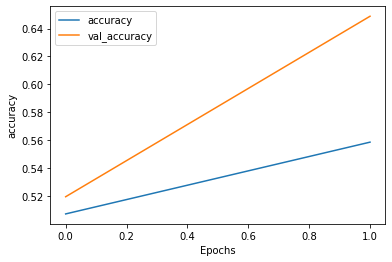

In [75]:
plot_graphs(history, 'accuracy')

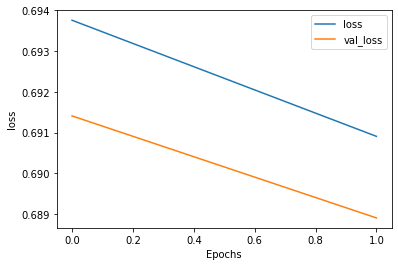

In [76]:
plot_graphs(history, 'loss')

In [77]:
DATA_OUT_PATH = './data_out/'
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'

test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen = test_input.shape[1])

SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [78]:
predictions = model.predict(test_input, batch_size = BATCH_SIZE)
predictions= predictions.squeeze(-1)

test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle = True)

output = pd.DataFrame(data={"id" : list(test_id), "sentiment": list(predictions)})
output.to_csv(DATA_OUT_PATH + 'movie_review_result_cnn.csv', index = False, quoting = 3)

49/49 [==============================] - 1s 16ms/step


## **□한글 텍스트 분류**

### **데이터 다운로드 및 세팅**

---



In [79]:
!pwd
!git clone https://github.com/e9t/nsmc.git/
ratings = pd.read_csv('./nsmc/ratings.txt', header = 0, delimiter = '\t', quoting = 3)

/content
Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 23.69 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [80]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(ratings, test_size=0.25)

Text(0, 0.5, 'Number of Review')

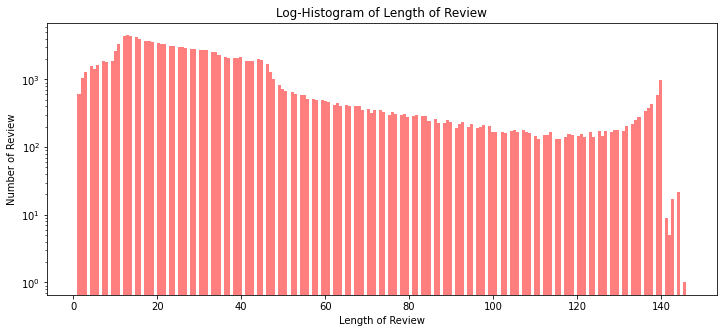

In [81]:
train_length = train_data['document'].astype(str).apply(len)
plt.figure(figsize=(12,5))
plt.hist(train_length, bins=200, alpha = 0.5, color = 'r', label = 'word')
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of Length of Review')
plt.xlabel('Length of Review')
plt.ylabel('Number of Review')

In [82]:
train_data['label']

149827    0
188508    0
1746      1
98825     1
43073     1
         ..
30046     1
95830     1
30986     1
121666    0
136945    0
Name: label, Length: 150000, dtype: int64

In [83]:
!pip3 install konlpy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 7.6 MB/s 
     |████████████████████████████████| 465 kB 72.6 MB/s 


### **데이터 전처리**
---

In [84]:
import numpy as np
import pandas as pd
import re
import json
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

def preprocessing(review,okt,remove_stopwords = False, stop_words = []):
  review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", review)
  word_review = okt.morphs(review_text, stem = True)

  if remove_stopwords:
    word_review = [token for token in word_review if not token in stop_words]
    
  return word_review

stop_words = set(['은','는','이','하','하','아','것','들','의','있','되','수','보','주','등','한'])
okt = Okt()
clean_train_review = []

for review in train_data['document']:
  if type(review) == str:
    clean_train_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words = stop_words))
  else:
    clean_train_review.append([])

clean_train_review[:4]

[['웃음', '도', '없다', '감동', '도', '없다', '게', '무슨', '영화', '야'],
 ['얼마나', '지루하다', '상상', '하다', '말르다', '그', '이상', '으로', '지루하다', '이다'],
 ['친구', '이랑', '같이', '보다', '재밌다', 'ㅋ'],
 ['전', '지금', '도', '반복', '하다', '보다', '거', '걸작', '이에요']]

In [85]:
clean_test_review = []
for review in test_data['document']:
  if type(review) == str:
    clean_test_review.append(preprocessing(review,okt,remove_stopwords = True, stop_words = stop_words))
  else:
      clean_test_review.append([])

In [86]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

word_vocab = tokenizer.word_index

MAX_SEQUENCE_LENGTH = 8

train_inputs = pad_sequences(train_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
train_labels = np.array(train_data['label'])
test_inputs = pad_sequences(test_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
test_labels = np.array(test_data['label'])


In [87]:
DATA_IN_PATH = './data_in/'
TRAIN_INPUT_DATA =  'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'
TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'
DATA_OUT_PATH = './data_out/'
DATA_CONFIGS = 'data_configs.json'

data_configs = {}
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)+1

import os
if not os.path.exists(DATA_IN_PATH):
  os.makedirs(DATA_IN_PATH)

np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)

np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(DATA_IN_PATH + TEST_LABEL_DATA, 'wb'), test_labels)

json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'),ensure_ascii=False)

### **모델링**

---



In [88]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

from tqdm import tqdm

In [89]:

train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_input = pad_sequences(train_input, maxlen = train_input.shape[1])
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [90]:
#HyperParameter

model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 2
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name' : model_name,
         'vocab_size' : prepro_configs['vocab_size'],
         'embedding_size' : 128,
         'num_filters' : 100,
         'dropout_rate' : 0.5,
         'hidden_dimension' : 250,
         'output_dimension' : 1}

In [91]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation=tf.keras.activations.relu,
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                     for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                           activation=tf.keras.activations.relu,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    
    def call(self,x):
      x = self.embedding(x)
      x = self.dropout(x)
      x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis =-1)
      x = self.fc1(x)
      x = self.fc2(x)

      return x

In [92]:
model = CNNClassifier(**kargs)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out/cnn_classifier_kr -- Folder create complete 



In [93]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/2
264/264 [==============================] - ETA: 0s - loss: 0.4598 - accuracy: 0.7755
Epoch 1: val_accuracy improved from -inf to 0.81593, saving model to ./data_out/cnn_classifier_kr/weights.h5
264/264 [==============================] - 4s 10ms/step - loss: 0.4598 - accuracy: 0.7755 - val_loss: 0.3973 - val_accuracy: 0.8159
Epoch 2/2
264/264 [==============================] - ETA: 0s - loss: 0.3540 - accuracy: 0.8448
Epoch 2: val_accuracy improved from 0.81593 to 0.82107, saving model to ./data_out/cnn_classifier_kr/weights.h5
264/264 [==============================] - 3s 10ms/step - loss: 0.3540 - accuracy: 0.8448 - val_loss: 0.3852 - val_accuracy: 0.8211


In [94]:
test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input,maxlen =test_input.shape[1])
test_label_data = np.load(open(DATA_IN_PATH + TEST_LABEL_DATA, 'rb'))

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, 'weights.h5'))
model.evaluate(test_input, test_label_data)

1563/1563 [==============================] - 4s 3ms/step - loss: 0.3844 - accuracy: 0.8252


[0.3843579590320587, 0.8252000212669373]